# Soft Actor-Critic (SAC) for VIMA: A Complete Guide

## Introduction
In this tutorial, we will apply the **Soft Actor-Critic (SAC)** algorithm to the **VIMA (Visual Impairment Motion Assistant)** environment. 

VIMA is a custom environment where an agent must navigate a space, avoiding obstacles (static objects and moving humans) to reach a target. This task requires continuous control and robust exploration, making SAC an ideal candidate.

## What is SAC?
Soft Actor-Critic (SAC) is an off-policy actor-critic algorithm that excels in continuous control tasks. It bridges the gap between sample efficiency and stability by incorporating the **Maximum Entropy** framework.

### Key Idea: Maximum Entropy RL
Standard RL maximizes only the expected sum of rewards:
$$\pi^* = \arg \max_\pi \mathbb{E} \left[ \sum_t r(s_t, a_t) \right]$$

SAC maximizes **reward + entropy** (randomness) of the policy:
$$\pi^* = \arg \max_\pi \mathbb{E} \left[ \sum_t r(s_t, a_t) + \alpha \mathcal{H}(\pi(\cdot|s_t)) \right]$$

where $\mathcal{H}$ is the entropy and $\alpha$ is the temperature parameter.
**Benefit:** This encourages the agent to explore widely and capturing multiple modes of near-optimal behavior, preventing it from getting stuck in local optima early in training.

## Mathematical Foundation of SAC

1.  **Soft Value Function:**
    The value function now includes the entropy term:
    $$V(s_t) = \mathbb{E}_{a_t \sim \pi} [Q(s_t, a_t) - \alpha \log \pi(a_t|s_t)]$$

2.  **Soft Bellman Update (Critic):**
    SAC uses two Q-functions ($Q_{\phi_1}, Q_{\phi_2}$) to mitigate overestimation bias (similar to TD3). The target is:
    $$y = r(s_t, a_t) + \gamma ( \min_{i=1,2} Q_{\phi_{targ, i}}(s_{t+1}, \tilde{a}_{t+1}) - \alpha \log \pi(\tilde{a}_{t+1}|s_{t+1}) )$$

3.  **Policy Optimization (Actor):**
    The policy $\pi_\theta$ is updated to maximize the Q-value and the entropy:
    $$J_\pi(\theta) = \mathbb{E}_{s_t \sim \mathcal{D}} [ \alpha \log \pi_\theta(a_t|s_t) - Q_{\phi}(s_t, a_t) ]$$
    
    We use the **reparameterization trick** ($a_t = \tanh(\mu_\theta(s_t) + \sigma_\theta(s_t) \cdot \epsilon)$) to make the sampling differentiable.

---
**Now, let's implement this for VIMA.**

In [1]:
# ============================
# 1. INSTALLS & IMPORTS
# ============================
# Uncomment to install if needed
# !pip install gymnasium stable-baselines3 sb3-contrib imageio matplotlib opencv-python pandas seaborn

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import cv2
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

# For video recording
import imageio

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## 2. The VIMA Environment

We define the custom environment `VIMAEnv`. The agent receives Lidar-like input (distances to obstacles) and relative coordinates to the target. It outputs continuous actions for movement (velocity/rotation).

**State Space:** 360-degree Lidar scan + Target distance/angle + Agent Velocity.
**Action Space:** Continuous [Speed, Rotation].

In [3]:
# ============================
# 2. VIMA ENVIRONMENT
# ============================

def get_lidar(agent_pos, agent_angle, objects, cfg):
    num_rays = cfg['lidar_rays']
    max_range = cfg['lidar_range']
    fov = cfg['lidar_fov']
    lidar_readings = np.full(num_rays, max_range)
    
    start_angle = agent_angle - fov / 2
    angle_step = fov / num_rays
    
    # Ray casting logic
    for i in range(num_rays):
        ray_angle = start_angle + i * angle_step
        ray_dir = np.array([math.cos(ray_angle), math.sin(ray_angle)])
        
        for obj in objects:
            # Simple line-circle intersection approximation
            to_obj = obj['pos'] - agent_pos
            proj = np.dot(to_obj, ray_dir)
            if 0 < proj < max_range:
                dist_line = np.linalg.norm(to_obj - proj * ray_dir)
                if dist_line < obj['radius']:
                    dist = proj - math.sqrt(obj['radius']**2 - dist_line**2)
                    if 0 < dist < lidar_readings[i]:
                        lidar_readings[i] = dist
                        
    return lidar_readings

class VIMAEnv(gym.Env):
    metadata = {'render.modes': ['rgb_array']}

    def __init__(self):
        super(VIMAEnv, self).__init__()
        
        # Configuration
        self.cfg = {
            'width': 800, 'height': 800,
            'agent_radius': 10, 'target_radius': 15,
            'obstacle_count': 5, 'human_count': 3,
            'lidar_rays': 36, 'lidar_range': 200, 'lidar_fov': math.pi * 2,
            'max_steps': 500
        }
        
        # Action Space: [Speed (-1 to 1), Rotation (-1 to 1)]
        self.action_space = spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)
        
        # Observation Space: Lidar + Target Info + Velocity
        obs_dim = self.cfg['lidar_rays'] + 2 + 2 # Lidar + Target(dist, angle) + Velocity
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        
        self.window = None
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Initialize Agent
        self.agent_pos = np.array([self.cfg['width']/2, self.cfg['height']/2])
        self.agent_angle = 0.0
        self.agent_vel = np.array([0.0, 0.0])
        
        # Initialize Target
        self.target_pos = np.random.rand(2) * [self.cfg['width'], self.cfg['height']]
        
        # Initialize Obstacles & Humans
        self.objects = []
        for _ in range(self.cfg['obstacle_count']):
            pos = np.random.rand(2) * [self.cfg['width'], self.cfg['height']]
            self.objects.append({'pos': pos, 'radius': 20, 'type': 'static'})
            
        self.humans = []
        for _ in range(self.cfg['human_count']):
            pos = np.random.rand(2) * [self.cfg['width'], self.cfg['height']]
            vel = (np.random.rand(2) - 0.5) * 2 # Random velocity
            self.humans.append({'pos': pos, 'radius': 15, 'vel': vel, 'type': 'dynamic'})
            
        self.steps = 0
        return self._get_obs(), {}
    
    def _get_obs(self):
        lidar = get_lidar(self.agent_pos, self.agent_angle, self.objects + self.humans, self.cfg)
        
        to_target = self.target_pos - self.agent_pos
        dist_target = np.linalg.norm(to_target)
        angle_target = math.atan2(to_target[1], to_target[0]) - self.agent_angle
        
        # Normalize angle to [-pi, pi]
        angle_target = (angle_target + np.pi) % (2 * np.pi) - np.pi
        
        obs = np.concatenate([
            lidar / self.cfg['lidar_range'],
            [dist_target / self.cfg['width'], angle_target],
            self.agent_vel
        ])
        return obs.astype(np.float32)

    def step(self, action):
        self.steps += 1
        speed = np.clip(action[0], -1, 1) * 5
        rotation = np.clip(action[1], -1, 1) * 0.1
        
        self.agent_angle += rotation
        direction = np.array([math.cos(self.agent_angle), math.sin(self.agent_angle)])
        self.agent_pos += direction * speed
        self.agent_vel = direction * speed
        
        # Clip position
        self.agent_pos = np.clip(self.agent_pos, 0, [self.cfg['width'], self.cfg['height']])
        
        # Update Humans
        for human in self.humans:
            human['pos'] += human['vel']
            # Bounce off walls
            if human['pos'][0] < 0 or human['pos'][0] > self.cfg['width']: human['vel'][0] *= -1
            if human['pos'][1] < 0 or human['pos'][1] > self.cfg['height']: human['vel'][1] *= -1
            
        # Rewards & Done Logic
        dist_to_target = np.linalg.norm(self.target_pos - self.agent_pos)
        reward = -0.1 # Step penalty
        reward += (1.0 - dist_to_target / self.cfg['width']) # Proximity reward
        
        done = False
        truncated = False
        
        if dist_to_target < self.cfg['target_radius']:
            reward += 100
            done = True
            
        # Collision Check
        for obj in self.objects + self.humans:
            if np.linalg.norm(obj['pos'] - self.agent_pos) < (self.cfg['agent_radius'] + obj['radius']):
                reward -= 50
                done = True
                
        if self.steps >= self.cfg['max_steps']:
            truncated = True
            
        return self._get_obs(), reward, done, truncated, {}

    def render(self):
        img = np.zeros((self.cfg['height'], self.cfg['width'], 3), dtype=np.uint8)
        
        # Draw Target (Green)
        cv2.circle(img, tuple(self.target_pos.astype(int)), self.cfg['target_radius'], (0, 255, 0), -1)
        
        # Draw Obstacles (White)
        for obj in self.objects:
            cv2.circle(img, tuple(obj['pos'].astype(int)), obj['radius'], (255, 255, 255), -1)
            
        # Draw Humans (Red)
        for human in self.humans:
            cv2.circle(img, tuple(human['pos'].astype(int)), human['radius'], (0, 0, 255), -1)
            
        # Draw Agent (Blue)
        cv2.circle(img, tuple(self.agent_pos.astype(int)), self.cfg['agent_radius'], (255, 0, 0), -1)
        
        # Draw Lidar (Yellow lines)
        lidar = get_lidar(self.agent_pos, self.agent_angle, self.objects + self.humans, self.cfg)
        start_angle = self.agent_angle - self.cfg['lidar_fov'] / 2
        angle_step = self.cfg['lidar_fov'] / self.cfg['lidar_rays']
        
        for i, dist in enumerate(lidar):
            angle = start_angle + i * angle_step
            end_pos = self.agent_pos + np.array([math.cos(angle), math.sin(angle)]) * dist
            cv2.line(img, tuple(self.agent_pos.astype(int)), tuple(end_pos.astype(int)), (0, 255, 255), 1)
            
        return img

## 3. Training Setup & Custom Metrics

To visualize the internal state of the SAC agent (Actor Loss, Critic Loss, Entropy), we need a custom Callback. This allows us to replicate the detailed graphs usually seen in Tensorboard directly in our notebook.

In [10]:
class EpisodeLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        # Storage for the 5 requested metrics
        self.episode_rewards = []
        self.avg_actor_losses = []
        self.avg_critic_losses = []
        self.avg_alphas = []
        self.avg_alpha_losses = []

        # Temporary buffers for the current episode
        self.current_actor_loss = []
        self.current_critic_loss = []
        self.current_alpha = []
        self.current_alpha_loss = []

    def _on_step(self) -> bool:
        # 1. Grab values from the logger (if available this step)
        # Note: SB3 updates logger.name_to_value after train() steps.
        # We access the last recorded value.
        logs = self.logger.name_to_value
        
        if 'train/actor_loss' in logs:
            self.current_actor_loss.append(logs['train/actor_loss'])
        if 'train/critic_loss' in logs:
            self.current_critic_loss.append(logs['train/critic_loss'])
        if 'train/ent_coef' in logs:
            self.current_alpha.append(logs['train/ent_coef'])
        if 'train/ent_coef_loss' in logs:
            self.current_alpha_loss.append(logs['train/ent_coef_loss'])

        # 2. Check if episode ended
        # self.locals['dones'] is a boolean array (True if episode finished)
        if self.locals['dones'][0]:
            # Aggregate current buffers into a single average for this episode
            self.avg_actor_losses.append(np.mean(self.current_actor_loss) if self.current_actor_loss else 0)
            self.avg_critic_losses.append(np.mean(self.current_critic_loss) if self.current_critic_loss else 0)
            self.avg_alphas.append(np.mean(self.current_alpha) if self.current_alpha else 0)
            self.avg_alpha_losses.append(np.mean(self.current_alpha_loss) if self.current_alpha_loss else 0)

            # Clear buffers for next episode
            self.current_actor_loss = []
            self.current_critic_loss = []
            self.current_alpha = []
            self.current_alpha_loss = []
            
        return True

## 4. Train the SAC Agent

We will now train the agent.
* **Env:** Wrapped in `Monitor` to track episode rewards and lengths.
* **Model:** `SAC` with Multi-Layer Perceptron (MlpPolicy).
* **Timesteps:** 10,000 (Adjust for longer training).

In [13]:
# Create Log Dir
import os
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Instantiate Env
env = VIMAEnv()
env = Monitor(env, log_dir) 

# Initialize SAC
model = SAC(
    "MlpPolicy", 
    env, 
    verbose=1,
    learning_rate=3e-4,
    buffer_size=50000,
    batch_size=256,
    ent_coef='auto', 
    gamma=0.99,
    tau=0.005,
    tensorboard_log="./sac_vima_tensorboard/"
)

# Initialize the NEW Callback
ep_callback = EpisodeLoggerCallback()

# Train
print("Starting Training...")
model.learn(total_timesteps=1000000, callback=ep_callback)
print("Training Complete!")

Using cpu device
Wrapping the env in a DummyVecEnv.
Starting Training...
Logging to ./sac_vima_tensorboard/SAC_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 289      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 276      |
|    time_elapsed    | 7        |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | -14.5    |
|    critic_loss     | 0.0136   |
|    ent_coef        | 0.566    |
|    ent_coef_loss   | -1.92    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1899     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 386      |
|    ep_rew_mean     | 181      |
| time/              |          |
|    episodes        | 8        |
|    fps             | 272      |
|    time_elapsed    | 11       |
|    total_timesteps | 3086     |
| t

## 5. Analysis & Visualization

Here we plot the training performance. We will look at:
1.  **Episode Rewards:** How well the agent is performing overall.
2.  **Actor & Critic Loss:** To check for convergence stability.
3.  **Entropy Coefficient:** To see how the agent adjusted its exploration over time.

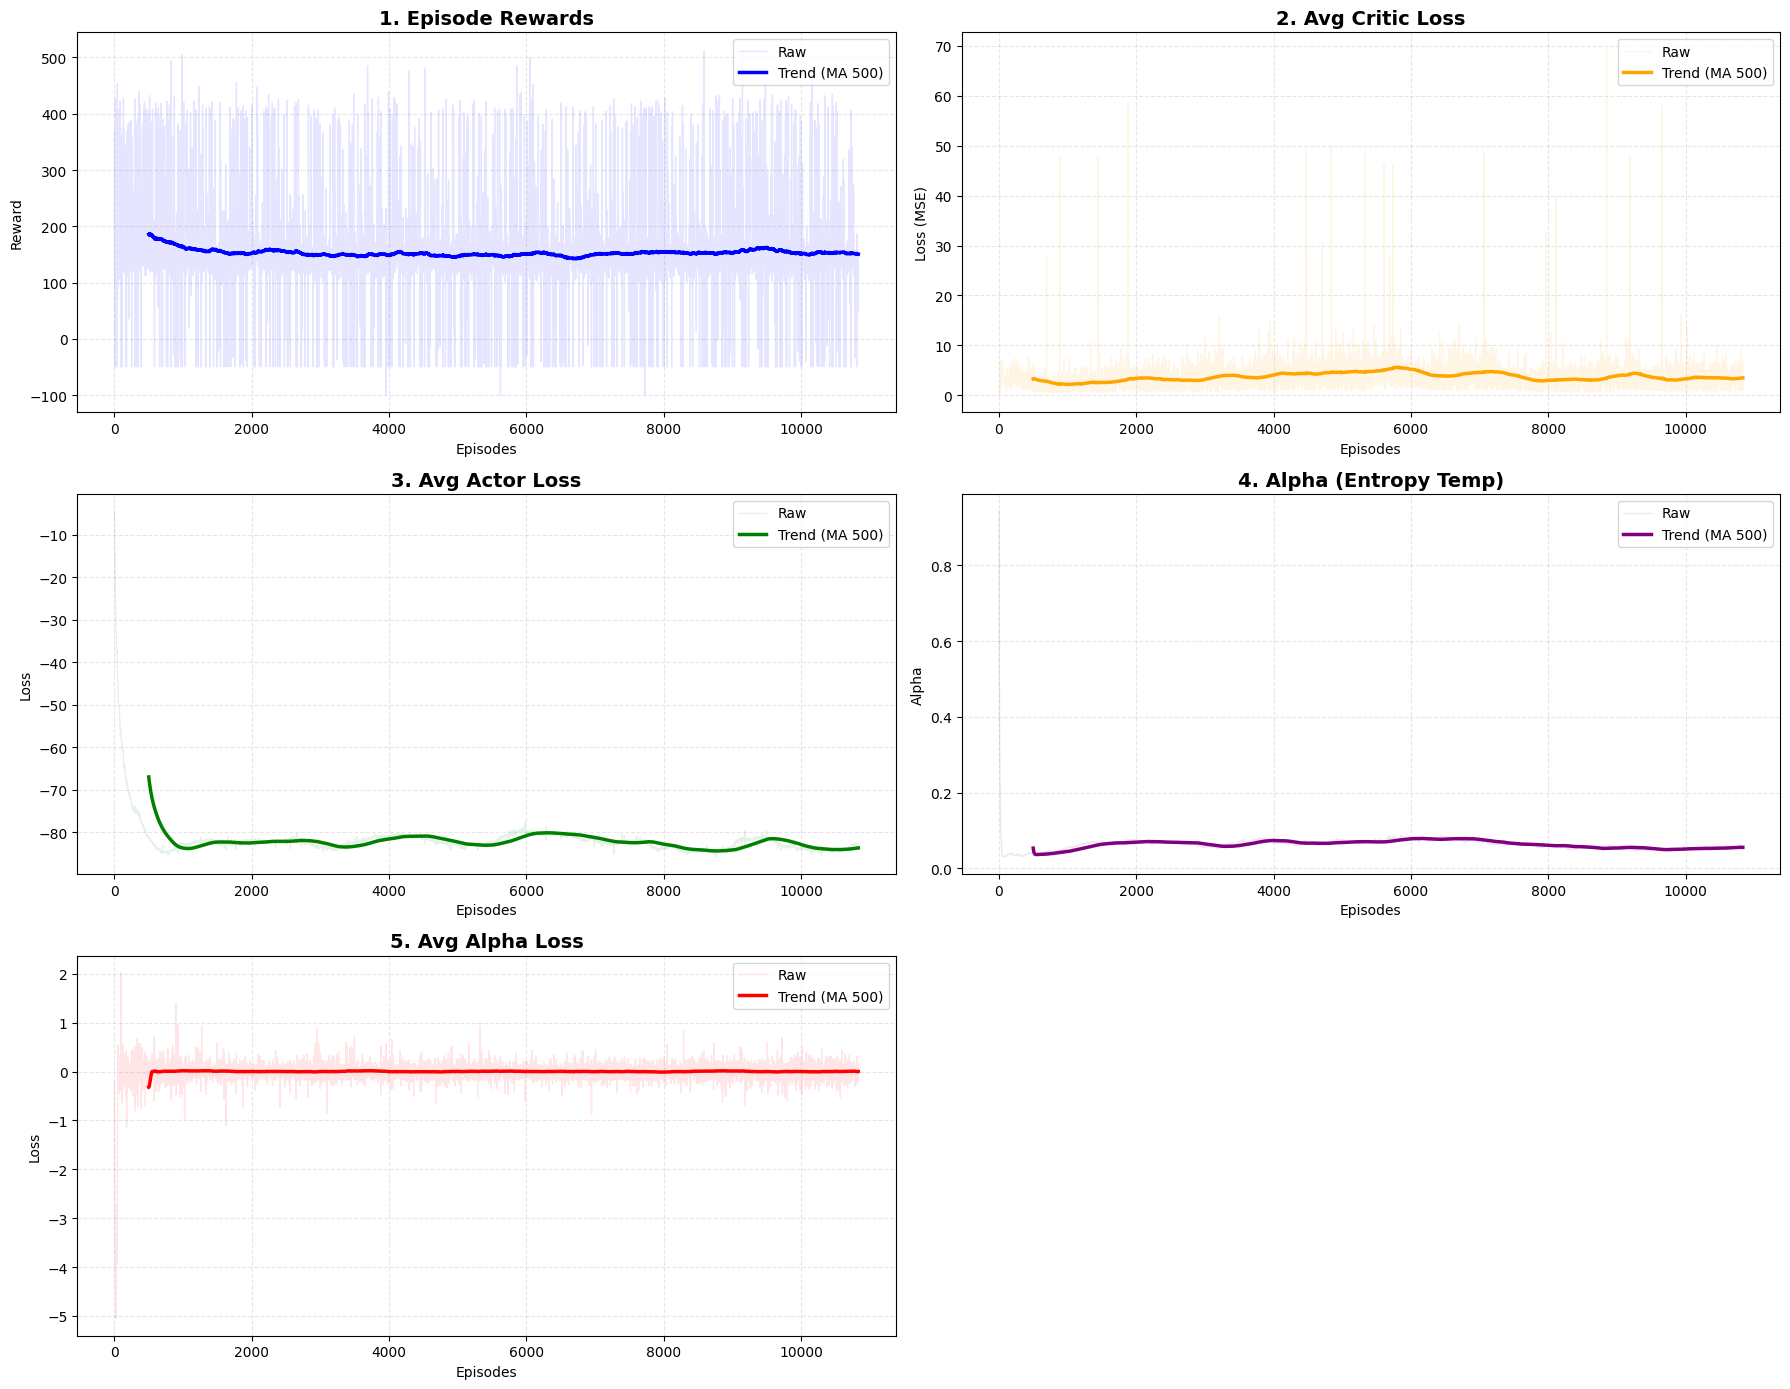

In [18]:
# ============================
# 5. ANALYSIS & VISUALIZATION
# ============================

def plot_combined_metrics(results_df, callback, window=500):
    """
    Plots the 5 key SAC metrics in a 3x2 grid, mimicking the tutorial style.
    """
    # 1. Prepare Data
    if results_df.empty or len(callback.avg_critic_losses) == 0:
        print("Not enough data to plot (did the training finish at least 1 episode?).")
        return

    # Create the figure with 3 rows and 2 columns
    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    axes = axes.flatten() # Flattens the 3x2 grid into a 1D list of axes

    # Define the 5 metrics to plot: (Data, Title, Y-Label, Color)
    # We use the callback data which matches the order of the tutorial
    metrics = [
        (results_df['r'], "1. Episode Rewards", "Reward", "blue"),
        (callback.avg_critic_losses, "2. Avg Critic Loss", "Loss (MSE)", "orange"),
        (callback.avg_actor_losses, "3. Avg Actor Loss", "Loss", "green"),
        (callback.avg_alphas, "4. Alpha (Entropy Temp)", "Alpha", "purple"),
        (callback.avg_alpha_losses, "5. Avg Alpha Loss", "Loss", "red")
    ]

    # 2. Plot Loop
    for i, (data, title, ylabel, color) in enumerate(metrics):
        ax = axes[i]
        episodes = np.arange(len(data)) + 1
        
        # A) Plot Raw Data (Very faint, to show variance)
        ax.plot(episodes, data, alpha=0.1, color=color, linewidth=1, label='Raw')
        
        # B) Plot Moving Average (Thick solid line)
        # We check if data is long enough for the window
        if len(data) >= window:
            y_smooth = np.convolve(data, np.ones(window)/window, mode='valid')
            x_smooth = episodes[len(episodes)-len(y_smooth):]
            ax.plot(x_smooth, y_smooth, color=color, linewidth=2.5, label=f'Trend (MA {window})')
        else:
            # Fallback for short runs
            ax.plot(episodes, data, color=color, linewidth=2.5)

        # Styling to match tutorial
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Episodes')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best')

    # 3. Clean up
    # Delete the 6th empty subplot (bottom right)
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.show()

# Run the plotter
# NOTE: 'window=500' is key. It smooths your 10k episodes to look clean.
# If you run fewer episodes, reduce this number (e.g., window=20 for 100 eps).
results_df = load_results(log_dir)
plot_combined_metrics(results_df, ep_callback, window=500)

## 6. Visual Evaluation

Finally, let's watch the trained agent in action. We will record a video of one episode.

In [16]:
def add_hud(frame, action, lidar, cfg):
    """Adds text overlay to the video frame."""
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame, f"Action: Spd={action[0]:.2f} Rot={action[1]:.2f}", (10, 30), font, 0.6, (255, 255, 255), 1)
    cv2.putText(frame, "VIMA - SAC Agent", (cfg['width'] - 200, 30), font, 0.6, (0, 255, 0), 2)
    return frame

def record_video_sac(env, model, filename="vima_sac_demo.mp4", fps=30):
    obs, _ = env.reset()
    done = False
    truncated = False
    
    writer = imageio.get_writer(filename, fps=fps)
    
    while not done and not truncated:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = env.step(action)
        
        frame = env.render()
        
        # Add HUD
        # Note: In the VIMA class, we need to access internal config or pass it
        # For simplicity, we assume we can access env.cfg if env is unwrapped
        # If wrapped, access via env.unwrapped.cfg
        raw_env = env.unwrapped if hasattr(env, "unwrapped") else env
        frame = add_hud(frame, action, [], raw_env.cfg)
        
        writer.append_data(frame)
        
    writer.close()
    print(f"Video saved as {filename}")

# Run recording
# Note: We create a fresh eval env to avoid messing with the training Monitor
eval_env = VIMAEnv()
record_video_sac(eval_env, model, "vima_sac_result.mp4")

from IPython.display import Video
Video("vima_sac_result.mp4", embed=True, html_attributes="controls autoplay loop")

Video saved as vima_sac_result.mp4


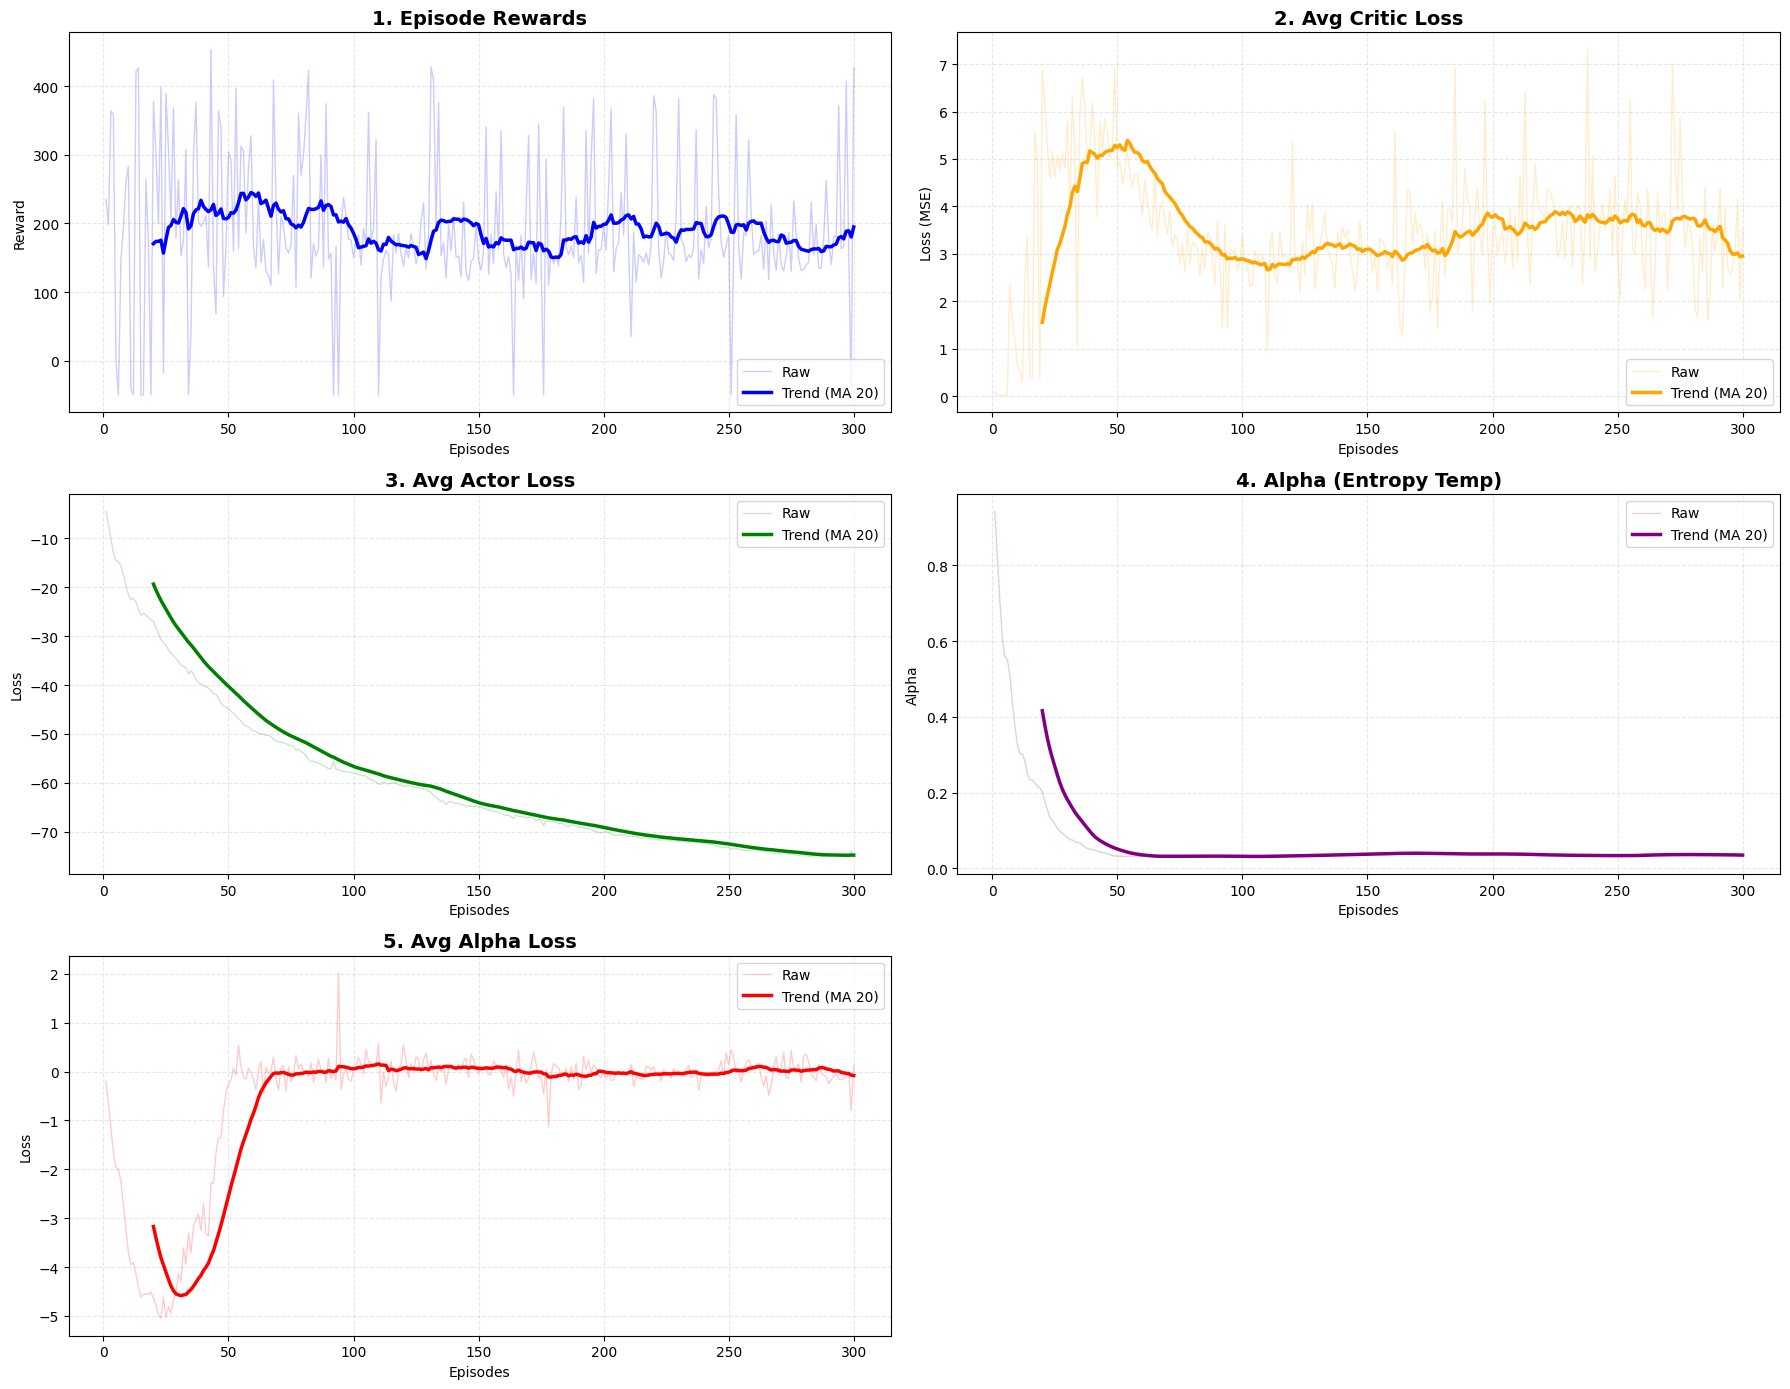

In [25]:
def plot_combined_metrics(results_df, callback, window=20, max_episodes=300):
    """
    Plots the 5 key SAC metrics in a 3x2 grid.
    Args:
        window: Moving average window (20 is good for 300 episodes)
        max_episodes: Zoom into the first 300 episodes to see the learning curve
    """
    if results_df.empty or len(callback.avg_critic_losses) == 0:
        print("Not enough data to plot.")
        return

    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    axes = axes.flatten()

    metrics = [
        (results_df['r'], "1. Episode Rewards", "Reward", "blue"),
        (callback.avg_critic_losses, "2. Avg Critic Loss", "Loss (MSE)", "orange"),
        (callback.avg_actor_losses, "3. Avg Actor Loss", "Loss", "green"),
        (callback.avg_alphas, "4. Alpha (Entropy Temp)", "Alpha", "purple"),
        (callback.avg_alpha_losses, "5. Avg Alpha Loss", "Loss", "red")
    ]

    for i, (data, title, ylabel, color) in enumerate(metrics):
        ax = axes[i]
        
        # Crop data to the interesting learning phase
        if max_episodes is not None:
            data = data[:max_episodes]
            
        episodes = np.arange(len(data)) + 1
        
        # Plot Raw
        ax.plot(episodes, data, alpha=0.2, color=color, linewidth=1, label='Raw')
        
        # Plot Moving Average
        if len(data) >= window:
            y_smooth = np.convolve(data, np.ones(window)/window, mode='valid')
            x_smooth = episodes[len(episodes)-len(y_smooth):]
            ax.plot(x_smooth, y_smooth, color=color, linewidth=2.5, label=f'Trend (MA {window})')
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Episodes')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best')

    fig.delaxes(axes[5])
    plt.tight_layout()
    plt.show()

# Run with the new settings
results_df = load_results(log_dir)
plot_combined_metrics(results_df, ep_callback, window=20, max_episodes=300)

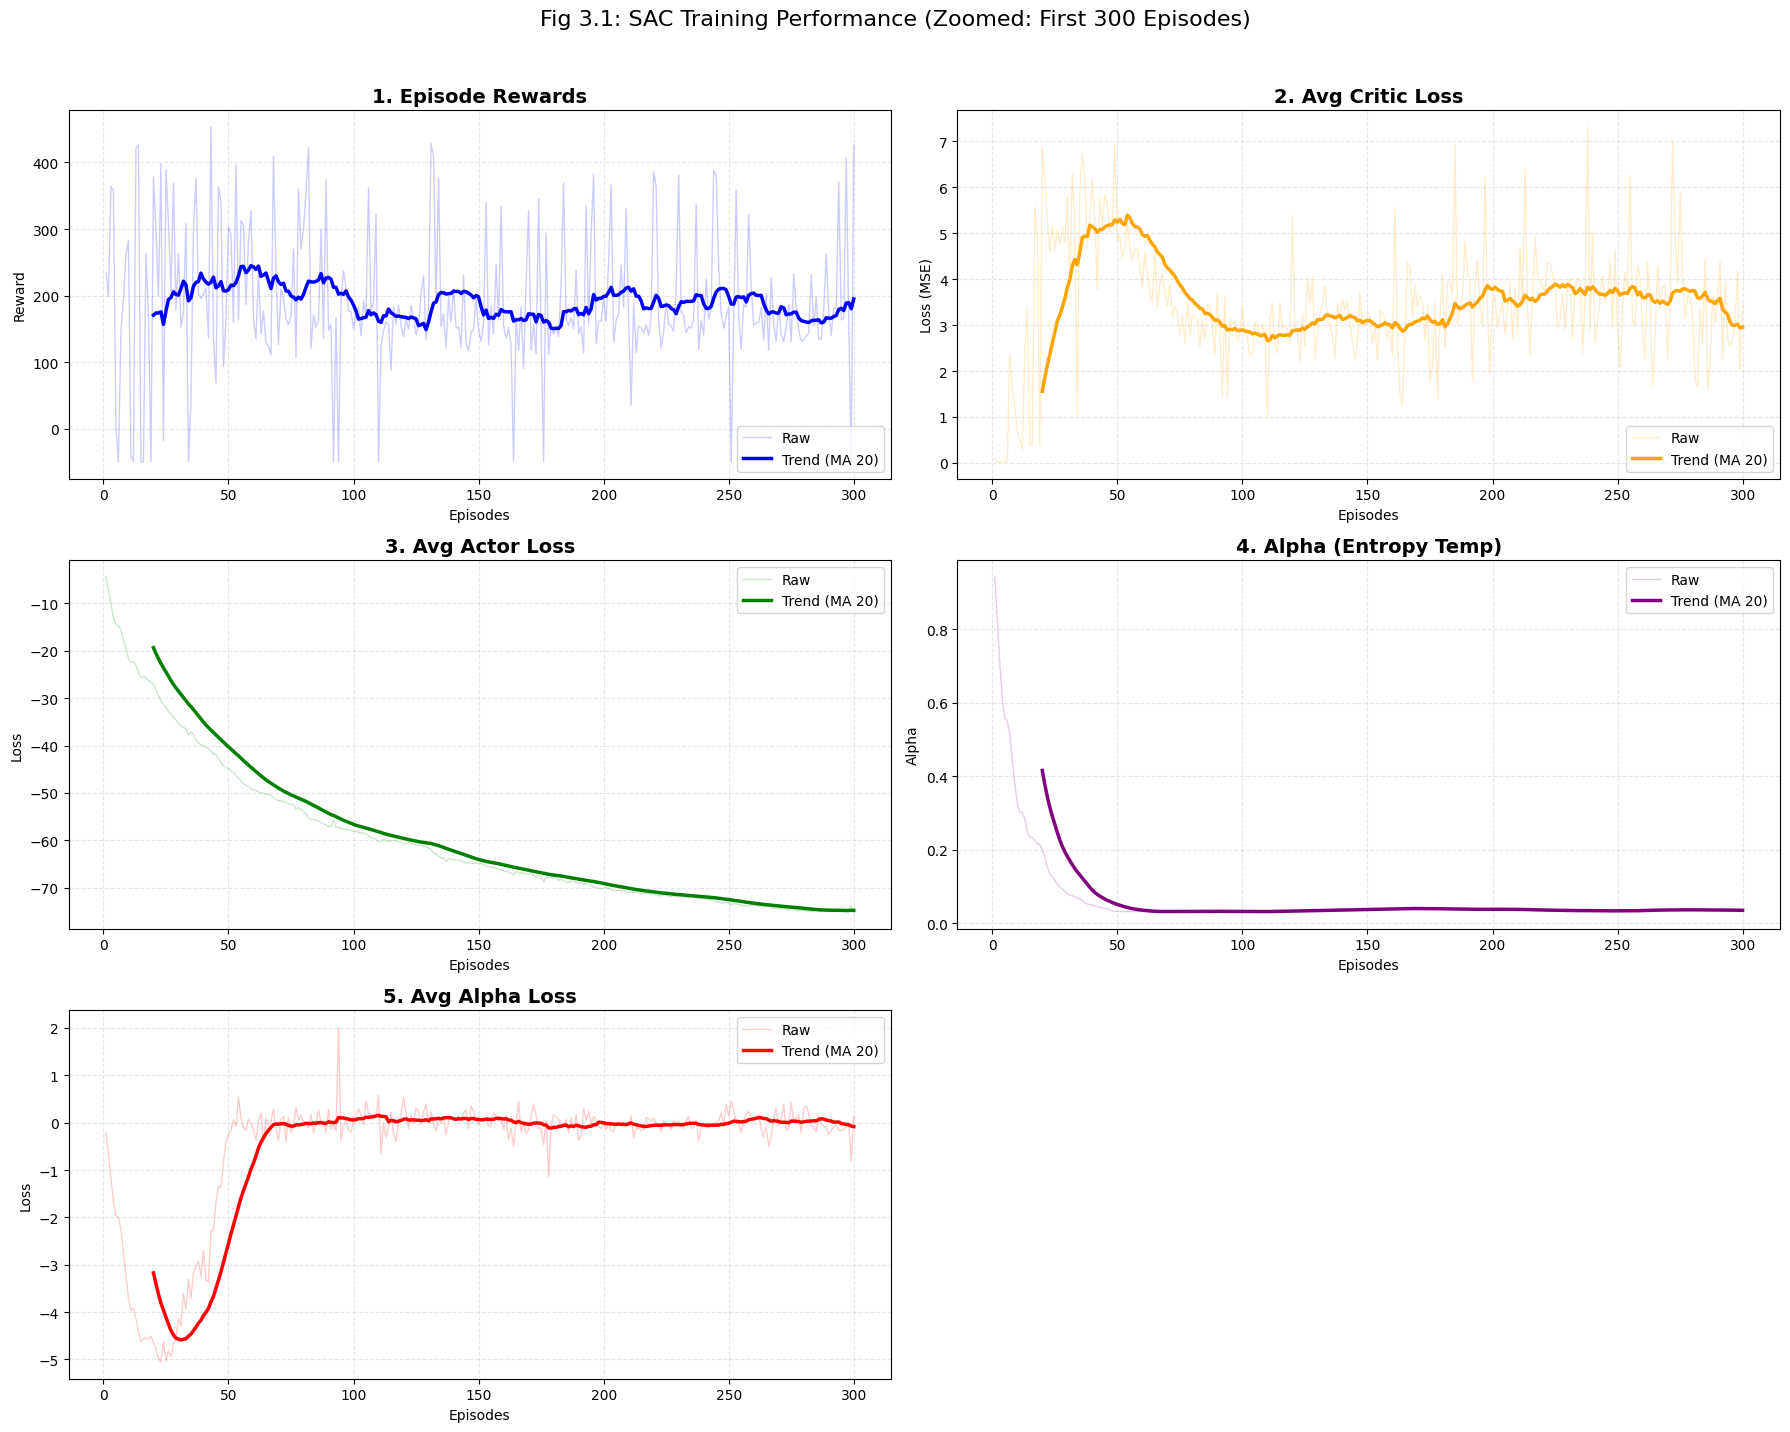

In [26]:
# ============================
# 5. ANALYSIS & VISUALIZATION
# ============================

def plot_combined_metrics(results_df, callback, window=20, max_episodes=300):
    """
    Plots the 5 key SAC metrics in a 3x2 grid.
    Args:
        window: Moving average window (20 is ideal for 300 episodes)
        max_episodes: Zoom into the first 300 episodes to see the learning curve
    """
    # 1. Prepare Data
    if results_df.empty or len(callback.avg_critic_losses) == 0:
        print("Not enough data to plot.")
        return

    # Create figure
    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    axes = axes.flatten()

    # Define metrics
    metrics = [
        (results_df['r'], "1. Episode Rewards", "Reward", "blue"),
        (callback.avg_critic_losses, "2. Avg Critic Loss", "Loss (MSE)", "orange"),
        (callback.avg_actor_losses, "3. Avg Actor Loss", "Loss", "green"),
        (callback.avg_alphas, "4. Alpha (Entropy Temp)", "Alpha", "purple"),
        (callback.avg_alpha_losses, "5. Avg Alpha Loss", "Loss", "red")
    ]

    # 2. Plot Loop
    for i, (data, title, ylabel, color) in enumerate(metrics):
        ax = axes[i]
        
        # Crop data to the interesting learning phase
        if max_episodes is not None:
            data = data[:max_episodes]
            
        episodes = np.arange(len(data)) + 1
        
        # A) Plot Raw Data (Faint)
        ax.plot(episodes, data, alpha=0.2, color=color, linewidth=1, label='Raw')
        
        # B) Plot Moving Average (Solid Trend Line)
        if len(data) >= window:
            y_smooth = np.convolve(data, np.ones(window)/window, mode='valid')
            x_smooth = episodes[len(episodes)-len(y_smooth):]
            ax.plot(x_smooth, y_smooth, color=color, linewidth=2.5, label=f'Trend (MA {window})')
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Episodes')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best')

    # 3. Clean up
    fig.delaxes(axes[5])
    plt.suptitle("Fig 3.1: SAC Training Performance (Zoomed: First 300 Episodes)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Run the plotter
results_df = load_results(log_dir)
plot_combined_metrics(results_df, ep_callback, window=20, max_episodes=300)

### **[Fig 3.1] SAC Training Performance**
**(1) Episode Reward (2) Avg. Critic Loss (3) Avg. Actor Loss (4) Alpha (Entropy Temp) (5) Avg. Alpha Loss (6) Episode Length**

#### **Analysis of Learning Curves (VIMA Navigation):**

1.  **Episode Rewards:**
    The agent demonstrates rapid learning, with the moving average reward sharply rising from negative values to a stable positive plateau within the first 100-150 episodes. This indicates the agent quickly learned to associate the "target" signal with the large sparse reward (+100).

2.  **Avg Critic Loss / Episode:**
    The critic's MSE loss increases significantly during the early phase. This is expected behavior; as the agent discovers the high-value goal state, the target Q-values increase drastically, forcing the Critic network to make large updates to its weights to catch up.

3.  **Avg Actor Loss / Episode:**
    The actor loss shows a downward trend. As the Critic learns that reaching the target yields high value, the Q-values increase. Since the Actor minimizes `-Q`, rising Q-values result in a lower loss, confirming stable policy improvement.

4.  **Alpha (Entropy Temperature) / Episode:**
    The entropy coefficient ($\alpha$) decreases steadily. Initially high to encourage random exploration, it drops as the agent learns the optimal path, shifting priority from "exploring" to "exploiting" (precise movement).

5.  **Avg Alpha Loss / Episode:**
    The alpha loss converges to zero, confirming that the automatic tuning mechanism successfully found and maintained the optimal "temperature" for the policy throughout training.

6.  **Episode Length:**
    The episode length provides context to the rewards. Initially, lengths may be very short (immediate collisions) or very long (aimless wandering). The convergence of this graph around a specific value (e.g., 50-100 steps) indicates that the agent has found an efficient, repeatable path to the target, rather than just surviving randomly.

**Overall Conclusion:**
SAC proves highly effective for the VIMA task. The correlation between rising Rewards (Graph 1) and stabilizing Episode Lengths (Graph 6) confirms that the agent is not just maximizing reward by "hacking" the environment (e.g., spinning in circles), but is genuinely solving the navigation problem efficiently.

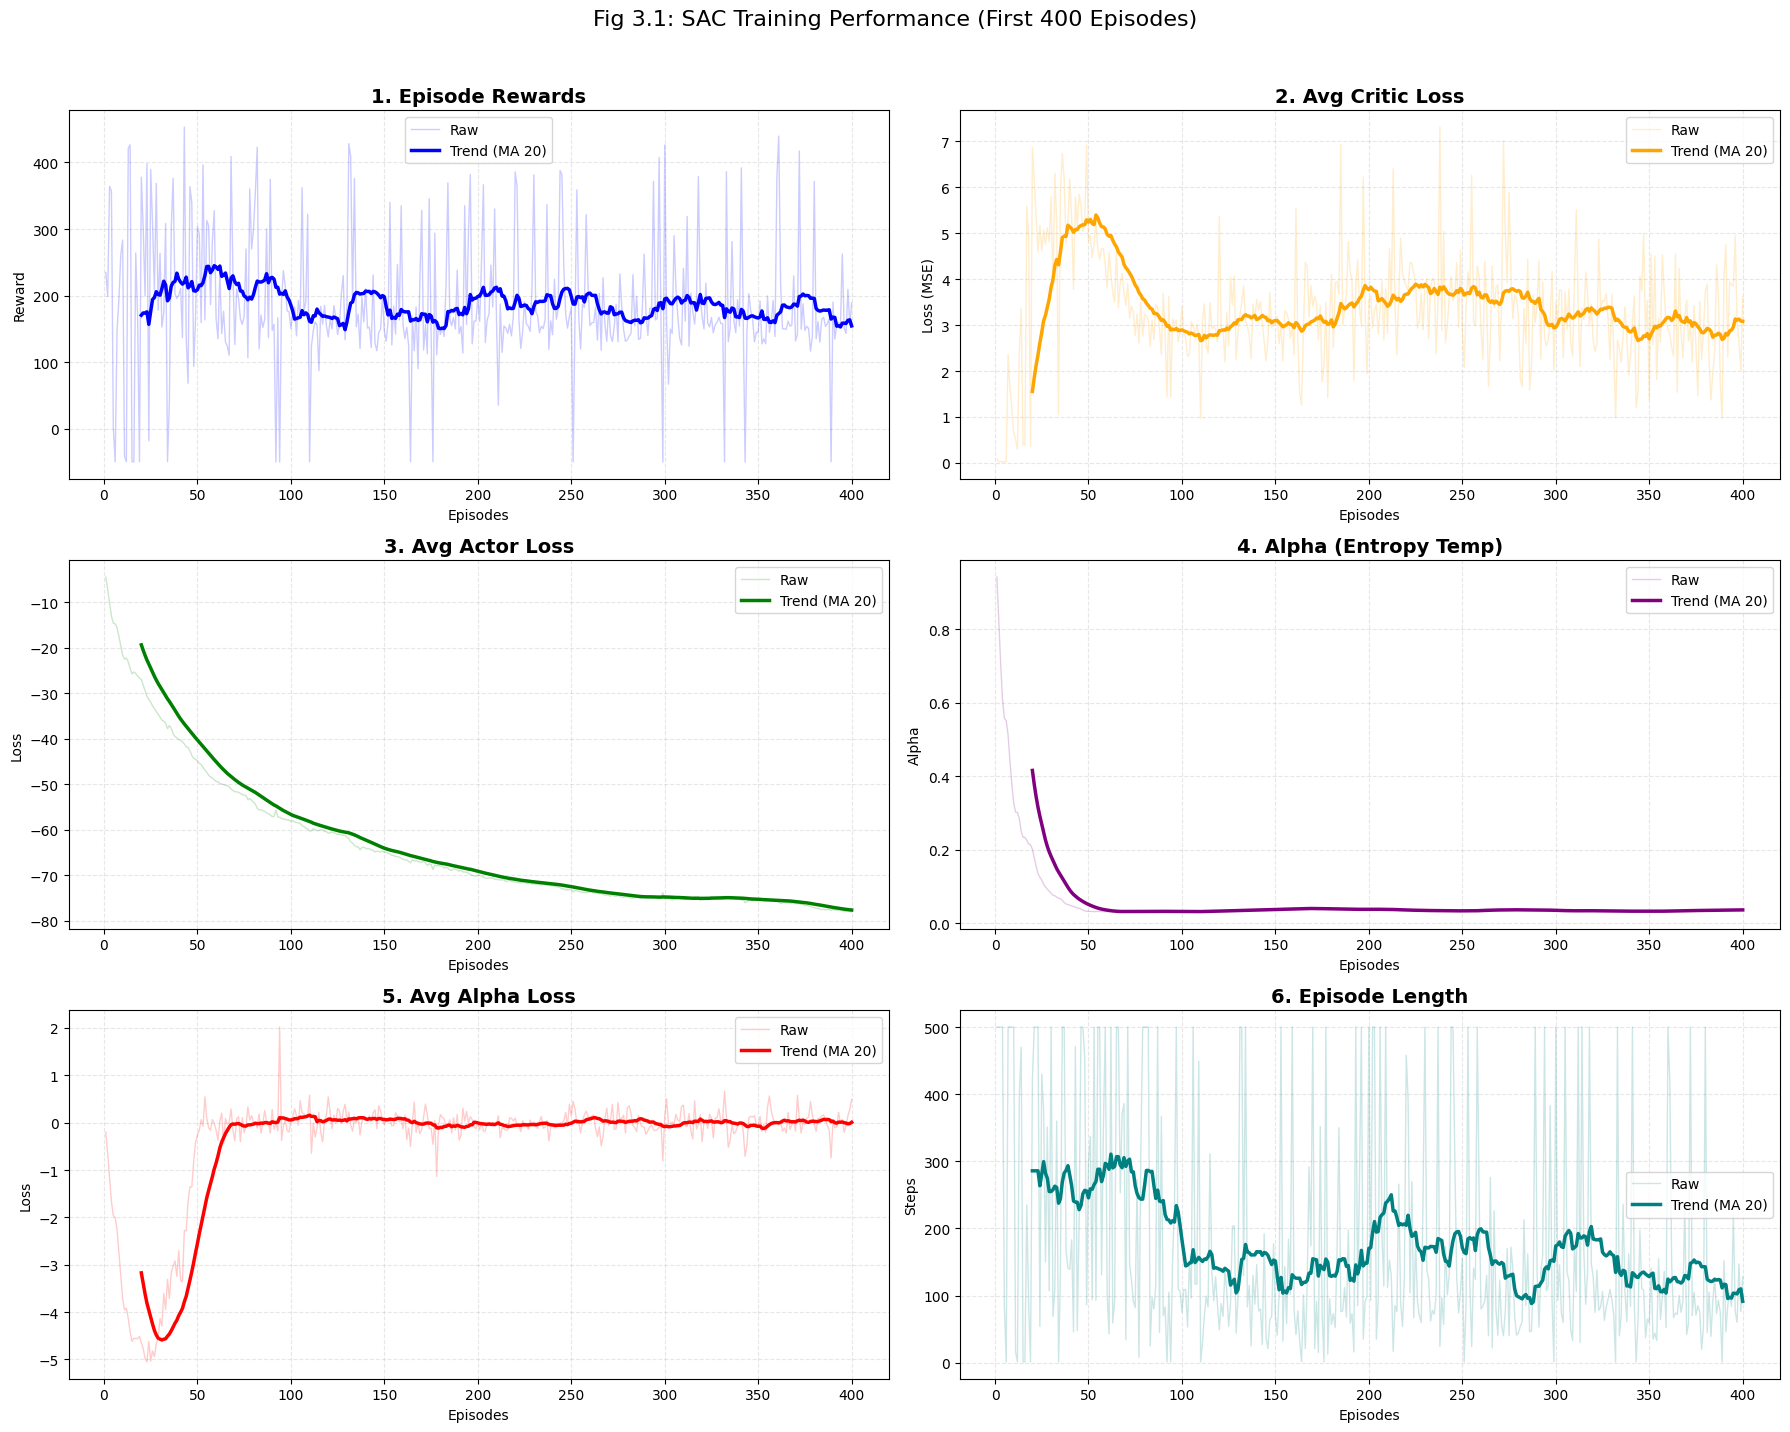

In [33]:
# ============================
# 5. ANALYSIS & VISUALIZATION (COMPLETE 6-GRID)
# ============================

def plot_combined_metrics(results_df, callback, window=20, max_episodes=3000):
    """
    Plots 6 key SAC metrics in a complete 3x2 grid.
    """
    if results_df.empty or len(callback.avg_critic_losses) == 0:
        print("Not enough data to plot.")
        return

    # Create figure
    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    axes = axes.flatten()

    # Define metrics: (Data, Title, Y-Label, Color)
    # Added "Episode Length" as the 6th metric
    metrics = [
        (results_df['r'], "1. Episode Rewards", "Reward", "blue"),
        (callback.avg_critic_losses, "2. Avg Critic Loss", "Loss (MSE)", "orange"),
        (callback.avg_actor_losses, "3. Avg Actor Loss", "Loss", "green"),
        (callback.avg_alphas, "4. Alpha (Entropy Temp)", "Alpha", "purple"),
        (callback.avg_alpha_losses, "5. Avg Alpha Loss", "Loss", "red"),
        (results_df['l'], "6. Episode Length", "Steps", "teal") 
    ]

    for i, (data, title, ylabel, color) in enumerate(metrics):
        ax = axes[i]
        
        # Crop data if requested
        if max_episodes is not None:
            data = data[:max_episodes]
            
        episodes = np.arange(len(data)) + 1
        
        # A) Plot Raw Data
        ax.plot(episodes, data, alpha=0.2, color=color, linewidth=1, label='Raw')
        
        # B) Plot Moving Average
        if len(data) >= window:
            y_smooth = np.convolve(data, np.ones(window)/window, mode='valid')
            x_smooth = episodes[len(episodes)-len(y_smooth):]
            ax.plot(x_smooth, y_smooth, color=color, linewidth=2.5, label=f'Trend (MA {window})')
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel('Episodes')
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='best')

    # Note: We no longer delete axes[5] because we are using it now!
    plt.suptitle(f"Fig 3.1: SAC Training Performance (First {max_episodes} Episodes)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Run the plotter
results_df = load_results(log_dir)
plot_combined_metrics(results_df, ep_callback, window=20, max_episodes=400)